# New York CitiBike Data Science Challenge

Der Fahrradverleih CitiBike vermietet in New York über 12.000 Fahrräder an 750 
Verleihstationen. Somit ist CitiBike eine echte Alternative zu den herkömmlichen 
Transportmitteln, wie z.B. U-bahn oder Taxi. 

Nehme an, es wäre das Jahr 2018. Mit einem gültigen 24 Stunden (3 Tage) Pass bzw. einer 
jährlichen Mitgliedschaft können Kunden ein Fahrrad an einer Verleihstation abholen und an 
einer beliebigen Station wieder abgeben. CitiBike stellt die durch den Verleih gesammelten 
Daten der Öffentlichkeit zur Verfügung. Deine Aufgabe als Data Scientist ist es, CitiBike dabei zu
helfen diese Daten wertstiftend zu nutzen. 

In einem ersten Pilotprojekt sollst du hierfür die Daten analysieren und ein Modell bauen, mit 
welchem zwei Klassen von Nutzern identifiziert werden können; dies sind (i) customers (24 
Stunden/ 3 Tage Pass) und (ii) subscribers (jährliche Mitgliedschaft).

Eine Orientierungshilfe bei 
dieser Aufgabenstellung bieten dir die folgenen Arbeitsschritte:
 
1. Lade diese Daten von Citibike für das Jahr 2018 herunter. Mach dich mit dem Inhalt des 
Datensatzes vertraut und bereite ihn für weitere Analysen auf. 
2. Visualisiere die Daten; sei kreativ und überlege dir geeignete Darstellungsformen für 
deine Entdeckungen. Nutze die Visualisierungen auch in deiner Ergebnispräsentation um 
deine Argumente zu unterstützen.
3. Überlege dir geeignete Features (Merkmale) als Input für dein customer-subscriber-
Modell. Konstruiere gegebenenfalls neue Features um dein Modell zu verbessern. 
4. Verteste verschiedene Modelle bzw. Methoden zur Klassifikation der Kundentypen 
subscribers und customers. Evaluiere die Performance der unterschiedlichen Modelle 
und begründe eine Modellauswahl.
5. Skizziere mögliche Einsatzgebiete oder UseCases deiner Modelle
6. Skizziere für CitiBike Kooperationsmöglichkeiten mit einer Versicherung (und/oder 
umgekehrt). 
 


## Imports und Co

In [1]:
# Generelles
import os

# Data science
import numpy as np
import pandas as pd

# Machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

# Plotting
import matplotlib.pyplot as plt

# Hilfen
from utils import crow_distance
from utils import forward_feature_selection

# Display
pd.set_option('display.max_columns', 500)
%matplotlib inline 

# Random seed
random_seed = 1
np.random.seed(random_seed)

# Konstanten
data_drop = 0.99
max_trip_duration = 12 * 3600

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Datenvorbereitung

In [2]:
# Rohdaten einlesen, wir beschränken uns auf 1% der Daten um meine virtuelle Maschine zu schonen
data_directory = 'data_NY/'
files = sorted(os.listdir(data_directory))
for index, file in enumerate(files):
    if index == 0:
        data = pd.read_csv(data_directory+file)
        data.drop(np.random.choice(data.index, int(len(data)*data_drop), replace=False), inplace=True)
    else:
        data_tmp = pd.read_csv(data_directory+file)
        data_tmp.drop(np.random.choice(data_tmp.index, int(len(data_tmp)*data_drop), replace=False), inplace=True)
        data = pd.concat([data, data_tmp], ignore_index=True)

# Datentyp verbessern
for column in data.columns:
    data.rename(columns={column: column.replace(' ', '_')}, inplace=True)
data.starttime = pd.to_datetime(data.starttime)
data.stoptime = pd.to_datetime(data.stoptime)

# Rohdaten sichten
data

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,983,2018-01-10 12:58:15.735,2018-01-10 13:14:39.259,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3142.0,1 Ave & E 62 St,40.761227,-73.960940,30780,Subscriber,1970,2
1,450,2018-01-10 17:36:02.627,2018-01-10 17:43:33.465,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,31119,Subscriber,1962,1
2,827,2018-01-12 16:54:32.752,2018-01-12 17:08:20.002,72.0,W 52 St & 11 Ave,40.767272,-73.993929,490.0,8 Ave & W 33 St,40.751551,-73.993934,31190,Subscriber,1982,1
3,1317,2018-01-13 11:10:35.832,2018-01-13 11:32:32.864,72.0,W 52 St & 11 Ave,40.767272,-73.993929,382.0,University Pl & E 14 St,40.734927,-73.992005,24941,Subscriber,1968,1
4,794,2018-01-15 09:31:28.869,2018-01-15 09:44:43.084,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3175.0,W 70 St & Amsterdam Ave,40.777480,-73.982886,30683,Subscriber,1966,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175485,1150,2018-12-31 19:57:08.159,2018-12-31 20:16:19.155,251.0,Mott St & Prince St,40.723180,-73.994800,327.0,Vesey Pl & River Terrace,40.715338,-74.016584,34090,Customer,1969,0
175486,1231,2018-12-31 21:17:22.775,2018-12-31 21:37:53.835,439.0,E 4 St & 2 Ave,40.726281,-73.989780,195.0,Liberty St & Broadway,40.709056,-74.010434,18096,Subscriber,1954,2
175487,234,2018-12-31 21:51:18.323,2018-12-31 21:55:12.906,229.0,Great Jones St,40.727434,-73.993790,3467.0,W Broadway & Spring Street,40.724947,-74.001659,34778,Subscriber,1993,1
175488,2657,2018-12-31 22:12:15.419,2018-12-31 22:56:33.020,3137.0,5 Ave & E 73 St,40.772828,-73.966853,236.0,St Marks Pl & 2 Ave,40.728419,-73.987140,14632,Subscriber,1969,0


In [ ]:
# Sanity checks der Rohdaten

print('Tripduration')
print(f'Min: {np.min(data.tripduration)} s, Max: {np.max(data.tripduration)/3600:.0f} h\n')

print('Starttime')
print(f'Min: {np.min(data.starttime)}, Max: {np.max(data.starttime)}\n')

print('Stoptime')
print(f'Min: {np.min(data.stoptime)}, Max: {np.max(data.stoptime)}\n')

print('Start station id')
print(f'Min: {np.min(data.start_station_id)}, Max: {np.max(data.start_station_id)}, #: {len(np.unique(data.start_station_id))}\n')

# print('Start station name')
# print(f'#: {len(np.unique(data.start_station_name))}\n')
      
print('Start station latitude')
print(f'Min: {np.min(data.start_station_latitude)}, Max: {np.max(data.start_station_latitude)}, #: {len(np.unique(data.start_station_latitude))}\n')

print('Start station longtude')
print(f'Min: {np.min(data.start_station_longitude)}, Max: {np.max(data.start_station_longitude)}, #: {len(np.unique(data.start_station_longitude))}\n')

print('End station id')
print(f'Min: {np.min(data.end_station_id)}, Max: {np.max(data.end_station_id)}, #: {len(np.unique(data.end_station_id))}\n')

# print('End station name')
# print(f'#: {len(np.unique(data.end_station_name))}\n')

print('End station latitude')
print(f'Min: {np.min(data.end_station_latitude)}, Max: {np.max(data.end_station_latitude)}, #: {len(np.unique(data.end_station_latitude))}\n')

print('End station longitude')
print(f'Min: {np.min(data.end_station_longitude)}, Max: {np.max(data.end_station_longitude)}, #: {len(np.unique(data.end_station_longitude))}\n')

print('Bikeid')
print(f'Min: {np.min(data.bikeid)}, Max: {np.max(data.bikeid)}, #: {len(np.unique(data.bikeid))}\n')

print('Usertype')
print(f'Types: {np.unique(data.usertype)}, #: {np.unique(data.usertype, return_counts=True)[1]}\n')

print('Birth year')
print(f'Min: {np.min(data.birth_year)}, Max: {np.max(data.birth_year)}\n')

print('Gender')
print(f'Types: {np.unique(data.gender)}, #: {np.unique(data.gender, return_counts=True)[1]}\n')

In [3]:
# Daten säubern

# Sortiere Fahrten aus, die länger als 2 Stunden dauerten
len_before = len(data)
data.drop(data[data.tripduration >= max_trip_duration].index, inplace=True)
len_after = len(data)
print(f'Dropped {len_before-len_after} lines due to excessive tripduration')

# Macht es Sinn, Geburtsjahre vor 1918 auszusortieren?

Dropped 72 lines due to excessive tripduration


### Erstes Fazit

- Datensatz sehr groß, wir beschränken uns deswegen auf die Sommermonate
- Datensatz ist 'imbalanced', 19 000 customer gegen 156 000 subscriber
- Datenqualität ist okay, aber ein paar sehr alte Kunden, lange Fahrten und unhomogene Koordinatenangaben
- Wir sollten schon vor der weiteren Analyse einen Teil der Daten beiseitelegen, um eine wirklich unabhängige Evaluation unseres Modells zu erreichen
- Wir sollten schon bei der visuellen Analyse des Datensatzes die Aufgabenstellung im Auge behalten

## Features für Customer-Subscriber-Modell

In [4]:
data['start_hour_of_day']= [t.hour for t in data.starttime]

data['start_day_of_week'] = [t.dayofweek for t in data.starttime]

data['start_day_of_year'] = [t.dayofyear for t in data.starttime]

data['duration_seconds'] = data.tripduration

data['crow_distance_meters'] = crow_distance(data.start_station_latitude, data.start_station_longitude, data.end_station_latitude, data.end_station_longitude)

data['crow_velocity_meters_per_second'] = data.crow_distance_meters / data.duration_seconds

data['age'] = 2018 - data.birth_year

data['gender_male'] = [1 if g==1 else 0 for g in data.gender]

data['gender_female'] = [1 if g==2 else 0 for g in data.gender]

data['gender_unknown'] = [1 if g==0 else 0 for g in data.gender]

data['customer'] = [1 if u=='Customer' else 0 for u in data.usertype]

data['subscriber'] = [1 if u=='Subscriber' else 0 for u in data.usertype]

data['set'] = [np.random.choice(['train', 'dev', 'test'], p=[0.8, 0.1, 0.1]) for r in range(len(data))]

data['train_set'] = [True if s=='train' else False for s in data.set]

data['dev_set'] = [True if s=='dev' else False for s in data.set]

data['test_set'] = [True if s=='test' else False for s in data.set]

data

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour_of_day,start_day_of_week,start_day_of_year,duration_seconds,crow_distance_meters,crow_velocity_meters_per_second,age,gender_male,gender_female,gender_unknown,customer,subscriber,set,train_set,dev_set,test_set
0,983,2018-01-10 12:58:15.735,2018-01-10 13:14:39.259,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3142.0,1 Ave & E 62 St,40.761227,-73.960940,30780,Subscriber,1970,2,12,2,10,983,2882.839542,2.932695,48,0,1,0,0,1,train,True,False,False
1,450,2018-01-10 17:36:02.627,2018-01-10 17:43:33.465,72.0,W 52 St & 11 Ave,40.767272,-73.993929,525.0,W 34 St & 11 Ave,40.755942,-74.002116,31119,Subscriber,1962,1,17,2,10,450,1418.276118,3.151725,56,1,0,0,0,1,train,True,False,False
2,827,2018-01-12 16:54:32.752,2018-01-12 17:08:20.002,72.0,W 52 St & 11 Ave,40.767272,-73.993929,490.0,8 Ave & W 33 St,40.751551,-73.993934,31190,Subscriber,1982,1,16,4,12,827,1898.782879,2.295989,36,1,0,0,0,1,train,True,False,False
3,1317,2018-01-13 11:10:35.832,2018-01-13 11:32:32.864,72.0,W 52 St & 11 Ave,40.767272,-73.993929,382.0,University Pl & E 14 St,40.734927,-73.992005,24941,Subscriber,1968,1,11,5,13,1317,3936.029514,2.988633,50,1,0,0,0,1,train,True,False,False
4,794,2018-01-15 09:31:28.869,2018-01-15 09:44:43.084,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3175.0,W 70 St & Amsterdam Ave,40.777480,-73.982886,30683,Subscriber,1966,2,9,0,15,794,1397.554981,1.760145,52,0,1,0,0,1,train,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175485,1150,2018-12-31 19:57:08.159,2018-12-31 20:16:19.155,251.0,Mott St & Prince St,40.723180,-73.994800,327.0,Vesey Pl & River Terrace,40.715338,-74.016584,34090,Customer,1969,0,19,0,365,1150,1859.902755,1.617307,49,0,0,1,1,0,train,True,False,False
175486,1231,2018-12-31 21:17:22.775,2018-12-31 21:37:53.835,439.0,E 4 St & 2 Ave,40.726281,-73.989780,195.0,Liberty St & Broadway,40.709056,-74.010434,18096,Subscriber,1954,2,21,0,365,1231,2445.477242,1.986578,64,0,1,0,0,1,train,True,False,False
175487,234,2018-12-31 21:51:18.323,2018-12-31 21:55:12.906,229.0,Great Jones St,40.727434,-73.993790,3467.0,W Broadway & Spring Street,40.724947,-74.001659,34778,Subscriber,1993,1,21,0,365,234,658.143203,2.812578,25,1,0,0,0,1,test,False,False,True
175488,2657,2018-12-31 22:12:15.419,2018-12-31 22:56:33.020,3137.0,5 Ave & E 73 St,40.772828,-73.966853,236.0,St Marks Pl & 2 Ave,40.728419,-73.987140,14632,Subscriber,1969,0,22,0,365,2657,5343.731703,2.011190,49,0,0,1,0,1,train,True,False,False


## Visualisierungen

In [ ]:
# histogramme, sortiert nach customer und Subscriber
plot_specs = [('start_hour_of_day', range(25)),
              ('start_day_of_week', range(7)),
              ('start_day_of_year', np.linspace(0, 366, num=20)),
              ('duration_seconds', np.linspace(0, 3600, num=20)),
              ('crow_distance_meters', np.linspace(0, 6000, num=20)),
              ('crow_velocity_meters_per_second', np.linspace(0, 6, num=20)),
              ('age', np.linspace(0, 80, num=20)),
              ('gender_male', range(3)),
              ('gender_female', range(3)),
              ('gender_unknown', range(3))]

data_customer = data[~data.test_set & data.customer==1]
data_subscriber = data[~data.test_set & data.subscriber==1]

for column, bins in plot_specs:
    plt.hist([data_customer[column], data_subscriber[column]], bins, stacked=True, rwidth=.95, color=['tomato', 'silver'])
    plt.title(f'{column} histogram')
    plt.show()
    plt.close()

In [ ]:
# Wegstrecken, ebenfalls nach customer und subscriber 
data_subscriber_for_plot = data_subscriber.drop(np.random.choice(data_subscriber.index, int(len(data_subscriber)*0.9), replace=False))
for idx, row in data_subscriber_for_plot.iterrows():
    plt.plot([row.start_station_longitude, row.end_station_longitude], [row.start_station_latitude, row.end_station_latitude], alpha=0.01, color='silver')
plt.title('subscriber frequent routes')
plt.show()
plt.close()

for idx, row in data_customer.iterrows():
    plt.plot([row.start_station_longitude, row.end_station_longitude], [row.start_station_latitude, row.end_station_latitude], alpha=0.01, color='tomato')
plt.title('customer frequent routes')
plt.show()
plt.close()

### Fazit zur Datenanalyse

- Subscriber fahren häufig zur Rush Hour
- Customer fahren langsamer und kürzere Strecken (Rundwege)
- Customer geben oft kein Geschlecht und ein standard-Alter an

## Modelle

In [7]:
# Inputs definieren
feature_columns = ['start_hour_of_day',
                   'start_day_of_week',
                   'start_day_of_year',
                   'duration_seconds',
                   'crow_distance_meters',
                   'crow_velocity_meters_per_second',
                   'age',
                   'gender_male',
                   'gender_female',
                   'gender_unknown']

target_column = ['customer']

# Training und validation Daten
x_train = data.loc[data.train_set, feature_columns]
x_dev = data.loc[data.dev_set, feature_columns]
y_train = data.loc[data.train_set, target_column]
y_dev = data.loc[data.dev_set, target_column]

In [ ]:
# Simples Modell fitten: immer als Subscriber klassifizieren
simple_model = lambda x: np.array([0]*len(x)) 
y_dev_hat_simple = simple_model(x_dev)

# Lineare Klassifikation fitten
linear_model = SGDClassifier(max_iter=1000, tol=1e-13)
linear_model.fit(x_train, y_train.to_numpy().reshape(-1))
y_dev_hat_linear = linear_model.predict(x_dev)

# Random forest für Klassifikation fitten
random_forest_model = RandomForestClassifier(n_estimators=500)
random_forest_model.fit(x_train, y_train.to_numpy().reshape(-1))
y_dev_hat_random_forest = random_forest_model.predict(x_dev)

In [ ]:
# Confusion matrix and accuracy score
plot_specs = [(y_dev_hat_simple, 'Simple model'),
              (y_dev_hat_linear, 'Linear model'),
              (y_dev_hat_random_forest, 'Random forest')]
for y_dev_hat, model_name in plot_specs:
    acc = accuracy_score(y_dev, y_dev_hat)
    disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat, cmap='Greys_r')
    plt.title(f'Confusion matrix for {model_name}, accuracy score {acc:.3f}')
    plt.show()
    plt.close()

In [ ]:
# Welche Fatures sind sinnvoll?
forward_feature_selection(data, feature_columns, target_column)

### Fazit zu Modellen

- Wegen dem imbalanced Problem bekommen wir bereits mit dem simplen Modell eine gute Accuracy
- Random Forest ist deutlich besser, verlässt sich aber zu einem Großteil auf die fehlenden Angaben der Customer. Daraus lassen sich schlecht weitere Verhaltensmuster ableiten

In [ ]:
# Simples Modell: Subscriber wenn Geschlecht unbekannt und Alter=Standardalter 49
def simple_model_2(x):
    y = np.array([0] * len(x))
    customer_indices = [(x.age==49)&(x.gender_unknown==1)][0]
    y[customer_indices] = 1
    return y
    
# Testen und visualisieren
y_dev_hat_simple_2 = simple_model_2(x_dev)
acc = accuracy_score(y_dev, y_dev_hat_simple_2)
disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat_simple_2, cmap='Greys_r')
plt.title(f'Confusion matrix for simple_model_2, accuracy score {acc:.3f}')
plt.show()
plt.close()


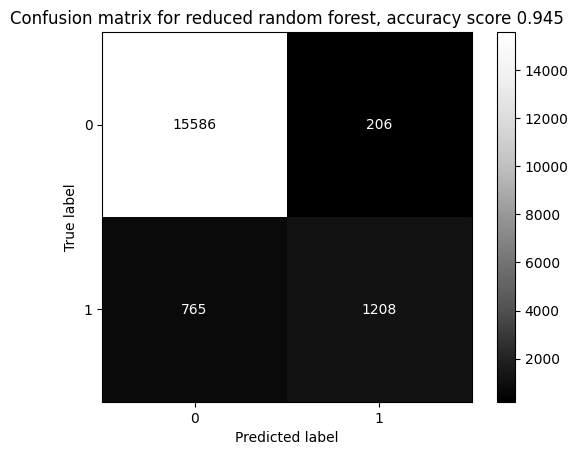

In [12]:


# Modell ohne unbekanntes Geschlecht und Alter
# Inputs definieren
feature_columns = ['start_hour_of_day',
                   'start_day_of_week',
                   'start_day_of_year',
                   'duration_seconds',
                   'crow_distance_meters',
                   'crow_velocity_meters_per_second',
                   # 'age',
                   'gender_male',
                   'gender_female',
                   # 'gender_unknown'
                  ]

target_column = ['customer']

# Training und validation Daten
x_train_r = data.loc[data.train_set, feature_columns]
x_dev_r = data.loc[data.dev_set, feature_columns]
y_train = data.loc[data.train_set, target_column]
y_dev = data.loc[data.dev_set, target_column]

# Random forest auf reduzierten Daten fitten
random_forest_model_r = RandomForestClassifier(n_estimators=500)
random_forest_model_r.fit(x_train_r, y_train.to_numpy().reshape(-1))
y_dev_hat_random_forest_r = random_forest_model_r.predict(x_dev_r)

# Testen und visualisieren
acc = accuracy_score(y_dev, y_dev_hat_random_forest_r)
disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat_random_forest_r, cmap='Greys_r')
plt.title(f'Confusion matrix for reduced random forest, accuracy score {acc:.3f}')
plt.show()
plt.close()

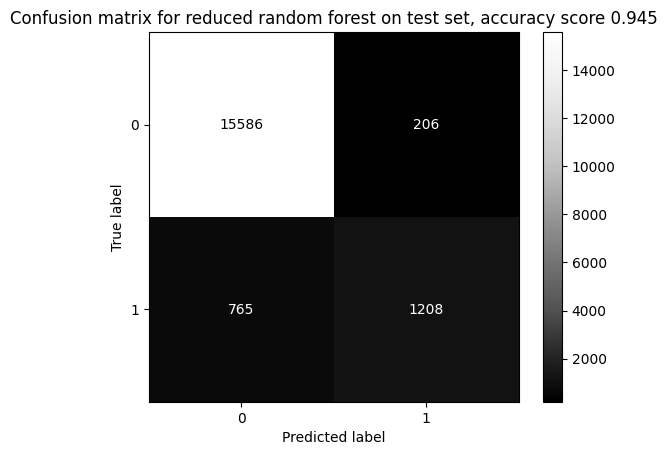

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


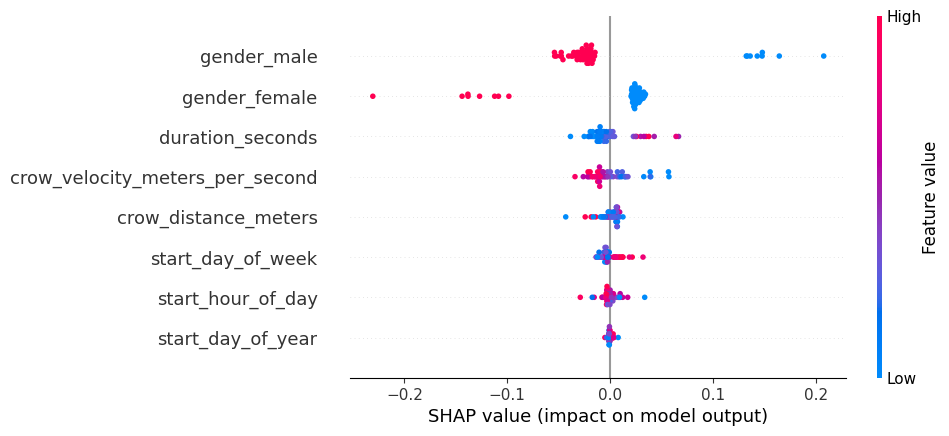

In [14]:
# Finales validieren und erklären
x_test_r = data.loc[data.test_set, feature_columns]
y_test = data.loc[data.test_set, target_column]

y_test_hat_random_forest_r = random_forest_model_r.predict(x_test_r)

acc = accuracy_score(y_dev, y_dev_hat_random_forest_r)
disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat_random_forest_r, cmap='Greys_r')
plt.title(f'Confusion matrix for reduced random forest on test set, accuracy score {acc:.3f}')
plt.show()
plt.close()


explainer = shap.Explainer(random_forest_model_r, x_test_r[0:50])
shap_values = explainer(x_test_r[0:50])
shap.plots.beeswarm(shap_values[:, :, 1])

### Fazit

- Diskutiere Erklärbarkeit durch Fahrverhalten
- ...

## Use cases für Modelle

- Fahrräder bereitstellen
- Kunden elastizität, vielleicht Pauschale erhöhen?

##  Kooperation mit Versicherung

- Gratulation zur subsciber base!
- Über subscriber wissen wir weniger, deshalb schwieriger zu versichern

## Was ich noch gemacht hätte, wenn ich Zeit gehabt hätte

- Datensatz als Graph betrachten, zwischen welchen Stationen fahren Customer und Subscriber gerne?
- Kein Jupyter, Random Seed überall fest machen, mehr estimators, besseres GitLab